In [7]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from numpy import deg2rad
from scipy.optimize import curve_fit
from scipy.ndimage import convolve1d
import seaborn as sns 
import sys
sys.path.append('/home/zilong/Desktop/HDPhasePrecession/CircularLinearReg')
from core import cl_corr
import HD_utils
from scipy.stats import wilcoxon, mannwhitneyu,ttest_ind
import warnings
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def load_data(ratname, file_path):
    # Load the .mat file
    with h5py.File(file_path, 'r') as f:
        # List all keys
        keys = list(f.keys())
        #print(f"Keys: {keys}")

        # Access the sdata structure
        sdata = f['sdata']

        # Check if 'light1' exists in sdata
        if 'light1' not in sdata:
            print(f"'light1' not found in {file_path}")
            return None

        # Accessing the light1 group and its datasets
        light1 = sdata['light1']
        ppox = np.array(light1['pox'])
        ppoy = np.array(light1['poy'])
        pot = np.array(light1['pot'])
        poh = np.array(light1['poh'])
        pov = np.array(light1['pov'])

        # Extract all cells containing the name 'R222'
        cell_names = [key for key in sdata.keys() if ratname in key]
        #print(f"Cell Names: {cell_names}")

        # Initialize dictionary to store data for all cells
        cells_data = {}

        # Iterate over each cell name and extract data
        for cell_name in cell_names:
            part_now = 'light1'  # Assuming 'light1' is the part_now equivalent

            pspx = np.array(sdata[cell_name][part_now]['spx'])
            pspy = np.array(sdata[cell_name][part_now]['spy'])
            pspt = np.array(sdata[cell_name][part_now]['spt'])
            pspv = np.array(sdata[cell_name][part_now]['spv'])
            psph = np.array(sdata[cell_name][part_now]['sph'])
            pspm = np.array(sdata[cell_name][part_now]['spm'])
            pval = np.array(sdata[cell_name][part_now]['pval'])
            spike_phase = np.array(sdata[cell_name][part_now]['spike_phase'])
            autocorrelogram = np.array(sdata[cell_name][part_now]['theta_train_long2'])
            hd_mean = np.array(sdata[cell_name][part_now]['hd_mean'])
            hd_std = np.array(sdata[cell_name][part_now]['hd_stdev'])
            tune_width = np.array(sdata[cell_name][part_now]['tuning_width'])

            # Extract and decode cell_type
            cell_type_array = np.array(sdata[cell_name][part_now]['thetacell_type'])
            cell_type = ''.join([chr(ascii_val[0]) for ascii_val in cell_type_array])

            # Store the data for this cell
            cells_data[cell_name] = {
                'pspx': pspx,
                'pspy': pspy,
                'pspt': pspt,
                'pspv': pspv,
                'psph': psph,
                'pspm': pspm,
                'pval': pval,
                'spike_phase': spike_phase,
                'autocorrelogram': autocorrelogram,
                'hd_mean': hd_mean,
                'hd_std': hd_std,
                'tune_width': tune_width,
                'cell_type': cell_type
            }

        # Create a dictionary to store all the data
        data_dict = {
            'ppox': ppox,
            'ppoy': ppoy,
            'pot': pot,
            'poh': poh,
            'pov': pov,
            'cell_names': cell_names,
            'cells_data': cells_data
        }

        return data_dict



In [3]:
def sinmodel(t, a, b, c, omega, t1, t2):
    return (a * (np.sin(2*np.pi*omega * t + np.pi/2) + 1) + b) * np.exp(-np.abs(t) / t1) + c * np.exp(-t**2 / t2**2) 

def calculate_intrinsic_frequency(autocorrelogram):
    
    # Fit the model to the autocorrelogram data
    initial_guess = [1, 1, 0.1, 9, 1.0, 0.01]  # Initial guesses for a, b, c, omega, t1, t2
    bounds = ([0, 0, 0, 6, 0, 0], [100, 100, 0.8, 12, 8, 0.05])  # Bounds for the parameters

    autocorr = autocorrelogram[0, :]
    #normalze autocorr to 0-1
    lags = autocorrelogram[1, :] / 1000.  # Convert lags to seconds

    params, _ = curve_fit(sinmodel, lags, autocorr, p0=initial_guess, bounds=bounds)
    # Extract the intrinsic frequency (omega)
    intrinsic_frequency = params[3]
    print(f"Intrinsic Theta Frequency: {intrinsic_frequency:.2f} Hz")
    
    return intrinsic_frequency, params

def skipmodel(t, a1, a2, b, c, omega, t1, t2):
    return (a1 * (np.cos(omega * t) + 1) + a2 * (np.cos(0.5*omega * t) + 1) + b) * np.exp(-np.abs(t) / t1) + c * np.exp(-t**2 / t2**2)

def calculate_skipping_index(autocorrelogram):
    # Fit the model to the autocorrelogram data
    initial_guess = [0.5, 0.5, 0.1, 0.1, 2 * 8 * np.pi, 0.01, 0.01]  # Initial guesses for a1, a2, b, c, omega, t1, t2
    bounds = ([0, 0, 0, 0, 12*np.pi, 0, 0], [100, 100, 100, 0.8, 24*np.pi, 8., 0.05])  # Bounds for the parameters

    autocorr = autocorrelogram[0, :]
    lags = autocorrelogram[1, :] / 1000  # Convert lags to seconds

    params, covariance = curve_fit(skipmodel, lags, autocorr, p0=initial_guess, bounds=bounds)
    omega = params[4] #freq

    # Calculate p1 and p2
    p1 = skipmodel(2 * np.pi / omega, *params)
    p2 = skipmodel(4 * np.pi / omega, *params)

    # Calculate the theta cycle skipping index
    TS = (p2 - p1) / max(p1, p2)
    
    print(f"Omega: {omega / (2 * np.pi):.2f} Hz")
    print(f"Theta Cycle Skipping Index: {TS:.2f}")
    
    return omega, TS, params  # Return frequency in Hz and the TS index

def get_phaseprecession(ppoh, pot, pspt, psph, hd_mean, spike_phase, config):
    
    spike_phase = spike_phase + np.pi #[-pi, pi] -> [0, 2pi]
    
    speed_threshold = config['speed_threshold']
    duration_threshold = config['duration_threshold']
    speed_smooth_sigma = config['speed_smooth_sigma']
    
    #calculate angular speed
    angular_speed = HD_utils.calculate_angular_speed(ppoh, pot, sigma=speed_smooth_sigma)
    
    #convert psph to radian
    psph = deg2rad(psph)
    hd_mean = deg2rad(hd_mean)
    
    psph_centered = np.mod(psph - hd_mean + np.pi, 2 * np.pi)
    
    #CCW plot in ax1
    continuous_periods_CCW = HD_utils.find_continuous_periods(angular_speed, pot, speed_threshold=-speed_threshold, duration_threshold=duration_threshold)
    indx = []
    for i in range(len(continuous_periods_CCW)):
        indx.extend(np.where((pspt > continuous_periods_CCW[i][0]) & (pspt < continuous_periods_CCW[i][1]))[0])
        
    psph_CCW = psph_centered[indx]
    spike_phase_CCW = spike_phase[indx]
    
    
    #CW plot in ax2
    continuous_periods_CW = HD_utils.find_continuous_periods(angular_speed, pot, speed_threshold=speed_threshold, duration_threshold=duration_threshold)
    #keep the index when pspt is within continuous_periods
    indx = [] 
    for i in range(len(continuous_periods_CW)):
        indx.extend(np.where((pspt > continuous_periods_CW[i][0]) & (pspt < continuous_periods_CW[i][1]))[0])
    
    psph_CW = psph_centered[indx]
    spike_phase_CW = spike_phase[indx]
    
    
    #ax3 plot
    #flip   psph_CCW by 2pi - psph_CCW
    psph_CCW = 2 * np.pi - psph_CCW
    #combine CCW and CW togther and plot
    psph_combined = np.concatenate((psph_CCW, psph_CW))
    spike_phase_combined = np.concatenate((spike_phase_CCW, spike_phase_CW))
    
    circ_lin_corr, pval, slope, phi0, RR = cl_corr(psph_combined, spike_phase_combined, min_slope=-1/2/np.pi, max_slope=1/2/np.pi, bootstrap_iter=1000, return_pval=True)
    

    return pval, circ_lin_corr


def plot_thetaskipping(ax, autocorrelogram):
    
    labelsize = 10
    ticksize = 8
    
    autocorr = autocorrelogram[0, :]

    ax.plot(autocorrelogram[1,:], autocorr, color='k', label='Autocorrelogram')
    #fill between y=0 and autocorrelogram
    ax.fill_between(autocorrelogram[1,:], 0, autocorr, color='k', alpha=1.0)

    omega, TS, params = calculate_skipping_index(autocorrelogram)

    #plot the fitted curve
    t = autocorrelogram[1,:]/1000
        
    ax.plot(t*1000, skipmodel(t, *params), color='red', label='Fitted curve', linewidth=1)
    
    #ax.legend(frameon=False, loc='upper center', fontsize=8, ncol=1, bbox_to_anchor=(0.5, 1.3))
    
    ax.set_xticks([-500, 0, 500])   
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) 
    
    ax.set_xlabel('Lag (ms)', fontsize=labelsize)
    #ax.set_ylabel('Autocorrelation', fontsize=labelsize)
    ax.set_title('TS: ' + str(np.round(TS, 2)), fontsize=labelsize)
    
    #set x and y tick fontsize to 8
    ax.tick_params(axis='x', which='major', labelsize=ticksize)
    ax.tick_params(axis='y', which='major', labelsize=ticksize)
    
    
    return ax, TS

def plot_head_direction_tuning(ax, ppoh, psph, config, pos_tb=0.02):
    """
    Plot the head direction tuning map in a polar plot.

    Parameters:
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        The polar axes to plot on.
    ppoh : np.array
        Array of session head direction angles in degrees.
    psph : np.array
        Array of cell head direction angles in degrees.
    pos_tb : float
        Time base for converting session HD to time.
    cell_name : str
        Name of the cell for which the tuning map is plotted.
    config : dict
        Configuration dictionary containing 'hd_bins' and 'hd_boxcar' parameters.
    """

    # Convert angles to radians
    ppoh_rad = deg2rad(ppoh)
    psph_rad = deg2rad(psph)

    # Calculate histograms for session and cell head directions
    hd1, _ = np.histogram(ppoh_rad, bins=config['hd_bins'], range=(0, 2 * np.pi))
    hd2, _ = np.histogram(psph_rad, bins=config['hd_bins'], range=(0, 2 * np.pi))

    # Boxcar filter
    boxcar_size = config['hd_boxcar']
    boxcar_filter = np.ones(boxcar_size) / boxcar_size

    # Apply boxcar filter
    hd1_filtered = convolve1d(hd1, boxcar_filter, mode='wrap')
    hd2_filtered = convolve1d(hd2, boxcar_filter, mode='wrap')

    # Convert session HD to time (i.e., dwelling time in each HD bin)
    hd1_time = hd1_filtered * pos_tb

    # Calculate HD firing rate
    hd3 = hd2_filtered / hd1_time

    # Normalize session HD
    hd1_normalized = hd1_time / np.max(hd1_time)

    # Normalize cell HD firing rate
    hd3_normalized = hd3 / np.max(hd3)
    hd3_normalized = hd3_normalized.flatten()

    # Close the loop by appending the first element to the end
    theta = np.linspace(0, 2 * np.pi, config['hd_bins'], endpoint=False)
    theta = np.append(theta, theta[0])
    hd1_normalized = np.append(hd1_normalized, hd1_normalized[0])
    hd3_normalized = np.append(hd3_normalized, hd3_normalized[0])

    # Plot the session head direction with shading
    ax.plot(theta, hd1_normalized, label='Session Head Direction', color='gray')
    ax.fill_between(theta, 0, hd1_normalized, facecolor='gray', alpha=0.2)

    # Plot the cell head direction firing rate
    ax.plot(theta, hd3_normalized, label='Cell Head Direction Firing Rate', color='#38c7ff')
    ax.fill_between(theta, 0, hd3_normalized, facecolor='#38c7ff', alpha=0.5)
    
    #calculate the preferred direction which corresponds to the peak of the tuning curve
    hd_peakfr = theta[np.argmax(hd3_normalized)]
    #add a line to indicate the preferred direction
    ax.plot([hd_peakfr, hd_peakfr], [0, 1], color='red', linestyle='--', linewidth=1)
    
    #instead, calculate the preferred direction using the circular mean
    hd_peakfr2 = np.angle(np.sum(np.exp(1j * psph_rad))) % (2 * np.pi)
    #add a line to indicate the preferred direction
    ax.plot([hd_peakfr2, hd_peakfr2], [0, 1], color='blue', linestyle='--', linewidth=1)
    

    #keep 0 90 180 270 as the xticks
    ax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2])
    ax.set_xticklabels(['0°', '90°', '180°', '270°'])
    
    #remove yticks
    ax.set_yticks([])
    
    #ax.set_title(cell_name + '\n'+str(np.round(hd_mean,1))+'('+str(np.round(hd_std,1))+')' +'\nRayleigh_p=' + str(np.round(pval, 4)), fontsize=10)
    
    #ax.set_title(f"{cell_name}\nAngle:{hd_mean:.0f} ({hd_std:.0f})\nTuning width:{tune_width:.0f}\nRayleigh_p={pval:.4f}", fontsize=10)
    # ax.legend()
    #set x and y tick as 8 pt
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

    return ax, hd_peakfr, hd_peakfr2


def plot_phaseprecession(ax, ppoh, pot, pspt, psph, hd_mean, spike_phase, config, addfitline=True):
    
    spike_phase = spike_phase + np.pi #[-pi, pi] -> [0, 2pi]
    
    alpha = 0.4
    speed_threshold = config['speed_threshold']
    duration_threshold = config['duration_threshold']
    speed_smooth_sigma = config['speed_smooth_sigma']
    
    #calculate angular speed
    angular_speed = HD_utils.calculate_angular_speed(ppoh, pot, sigma=speed_smooth_sigma)
    
    #convert psph to radian
    psph = deg2rad(psph)
    hd_mean = deg2rad(hd_mean)
    
    psph_centered = np.mod(psph - hd_mean + np.pi, 2 * np.pi)
    
    #CCW plot in ax1
    continuous_periods_CCW = HD_utils.find_continuous_periods(angular_speed, pot, speed_threshold=-speed_threshold, duration_threshold=duration_threshold)
    indx = []
    for i in range(len(continuous_periods_CCW)):
        indx.extend(np.where((pspt > continuous_periods_CCW[i][0]) & (pspt < continuous_periods_CCW[i][1]))[0])
        
    psph_CCW = psph_centered[indx]
    spike_phase_CCW = spike_phase[indx]
    
    
    #CW plot in ax2
    continuous_periods_CW = HD_utils.find_continuous_periods(angular_speed, pot, speed_threshold=speed_threshold, duration_threshold=duration_threshold)
    #keep the index when pspt is within continuous_periods
    indx = [] 
    for i in range(len(continuous_periods_CW)):
        indx.extend(np.where((pspt > continuous_periods_CW[i][0]) & (pspt < continuous_periods_CW[i][1]))[0])
    
    psph_CW = psph_centered[indx]
    spike_phase_CW = spike_phase[indx]
    
    
    #ax3 plot
    #flip   psph_CCW by 2pi - psph_CCW
    psph_CCW = 2 * np.pi - psph_CCW
    #combine CCW and CW togther and plot
    psph_combined = np.concatenate((psph_CCW, psph_CW))
    spike_phase_combined = np.concatenate((spike_phase_CCW, spike_phase_CW))
    
    circ_lin_corr, pval, slope, phi0, RR = cl_corr(psph_combined, spike_phase_combined, min_slope=-1/2/np.pi, max_slope=0, bootstrap_iter=3000, return_pval=True)

    #if len(psph_combined)>200 then random sample 200 points from it, otherwise plot all points
    if len(psph_combined) > np.inf:
        idx = np.random.choice(len(psph_combined), 200, replace=False)
        psph_combined = psph_combined[idx]
        spike_phase_combined = spike_phase_combined[idx]
         
        ax.scatter(psph_combined, spike_phase_combined, s=0.2, color='black', alpha=alpha)
        ax.scatter(psph_combined, [spike_phase_combined[i] + 2 * np.pi for i in range(len(spike_phase_combined))], s=0.2, color='black', alpha=alpha)
    else:
        ax.scatter(psph_combined, spike_phase_combined, s=0.2, color='black', alpha=alpha)
        ax.scatter(psph_combined, [spike_phase_combined[i] + 2 * np.pi for i in range(len(spike_phase_combined))], s=0.2, color='black', alpha=alpha)
        

    if addfitline:
        # Plot the circular-linear regression
        x = np.linspace(0, 2 * np.pi, 100)
        y = 2 * np.pi * slope * x + phi0
        ax.plot(x, y, color='red', linewidth=1)
        #add intercepr of 2*pi, and plot the line again
        y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
        ax.plot(x, y, color='red', linewidth=1)
        #add intercepr of 4*pi, and plot the line again
        y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
        ax.plot(x, y, color='red', linewidth=1)
        #substrac intercepr of 2*pi, and plot the line again
        y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
        ax.plot(x, y, color='red', linewidth=1)   
    
    ax.set_title('CL Corr: ' + str(np.round(circ_lin_corr, 2)), fontsize=10)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlim(0, 2*np.pi)
    ax.set_xticks([0, np.pi, 2*np.pi])
    ax.set_xticklabels(["$-\pi$", "$0$", "$\pi$"])
    
    ax.set_ylim(0, 4*np.pi)
    ax.set_yticks([0,  2*np.pi,  4*np.pi])
    ax.set_yticklabels(["$0$", "$2\pi$", "$4\pi$"])
    
    #set tick size as 8 using one line
    ax.tick_params(axis='both', labelsize=8)
    

    return ax, pval, circ_lin_corr


def get_adaptation(ppoh, pot, psph, pspt, hd_peakfr, degreerange=6, timelength=0.33, timecut=0.16):
    """
    Calculate adaptation based on periods when head direction (ppoh) is within the preferred range.

    Parameters:
        ppoh (numpy array): Rat head direction (in degrees).
        pot (numpy array): Timestamps for ppoh.
        psph: Head direction when a spike occurs.
        pspt: Accurate time when a spike occurs.
        hd_peakfr (float): Preferred direction (in radians).
        degreerange (int): Range around the preferred direction to consider (in degrees).

    Returns:
        list: A list of tuples where each tuple contains the start time, end time of a continuous period, 
              and the spike times within that period.
    """
    #ppoh to N dim not 1*N dim
    ppoh = ppoh.flatten()
    
    # Convert preferred direction from radians to degrees
    preferred_direction = np.rad2deg(hd_peakfr)

    # Calculate the wrapped difference between ppoh and preferred_direction
    diff = (ppoh - preferred_direction + 180) % 360 - 180

    # Assign True if the wrapped difference is within the degreerange, else False
    in_range = np.abs(diff) <= degreerange

    # Find the start and end indices of continuous periods using np.diff and np.where
    changes = np.diff(in_range.astype(int))
    start_indices = np.where(changes == 1)[0] + 1
    end_indices = np.where(changes == -1)[0]

    # Handle cases where the first or last period is continuous
    if in_range[0]:
        start_indices = np.insert(start_indices, 0, 0)
    if in_range[-1]:
        end_indices = np.append(end_indices, len(in_range) - 1)

    # Extract spike times within each continuous period
    results = []
    spikeratios = []
    
    inst_fr = []
    
    count = 0
    for start, end in zip(start_indices, end_indices):
        start_time = pot[start]
        end_time = pot[end]
        
        #if end_time - start_time < 0.3: do not consider this period
        if end_time - start_time < timelength:
            continue
        count += 1 

        # Find spike times within the period of start_time and start_time + timelength
        spikes_in_period = pspt[(pspt >= start_time) & (pspt <= start_time + timelength)]
        
        #get head direction when spikes occur for later sanity check
        # index = np.where((pspt >= start_time) & (pspt <= start_time + timelength))[0]
        # head_direction_at_spikes = psph[index]
        
        #count the number of spikes between start_time and start_time + timelength/2
        spikes_in_period_firsthalf = pspt[(pspt >= start_time) & (pspt <= start_time+timecut)]
        
        #count the number of spikes between start_time + timelength/2 and start_time + timelength
        spikes_in_period_secondhalf = pspt[(pspt > end_time - timecut) & (pspt <= end_time)]
        
        if len(spikes_in_period_firsthalf) < 2 or len(spikes_in_period_secondhalf) <2:
            continue
        else:
            #calculate the instantaneous firing rate
            initial_instfr = np.mean(1./np.diff(spikes_in_period_firsthalf))
            final_instfr = np.mean(1./np.diff(spikes_in_period_secondhalf))
            #calculate the firing rate by sum of spikes / time
            # initial_instfr = len(spikes_in_period_firsthalf) / (spikes_in_period_firsthalf[-1] - spikes_in_period_firsthalf[0])
            # final_instfr = len(spikes_in_period_secondhalf) / (spikes_in_period_secondhalf[-1] - spikes_in_period_secondhalf[0])
            
            inst_fr.append((initial_instfr, final_instfr))
            
            # spikeratio = (len(spikes_in_period_firsthalf) - len(spikes_in_period_secondhalf)) / (len(spikes_in_period_secondhalf) + len(spikes_in_period_firsthalf))
        
        # results.append((preferred_direction, start_time, end_time, head_direction_at_spikes, spikes_in_period, spikeratio))
        # print(start_time, end_time, len(spikes_in_period))
        
        # spikeratios.append(spikeratio)
        
        
    return inst_fr


In [4]:
def extract_initial_final_instfr(instfr):
    initial_instfr = []
    final_instfr = []
    for i in range(len(instfr)):
        if len(instfr[i]) == 0:
            continue
        else:
            for j in range(len(instfr[i])):
                initial_instfr.append(instfr[i][j][0])
                final_instfr.append(instfr[i][j][1])
    return initial_instfr, final_instfr

def get_adaptation_for_all(degreerange, timelength, timecut, return_mean=True):

    #do not show warnings
    warnings.filterwarnings("ignore")

    base_dir = '/home/zilong/Desktop/HDPhasePrecession/LomiData'

    # Configuration
    config = {
        'hd_bins': 60,
        'hd_boxcar': 3,
        'speed_threshold': 0.5,
        'duration_threshold': 0.5,
        'speed_smooth_sigma': 40,  #0.8,0.8,40 gives 43% pp cells
        'movingdirection_sigma': 5, #time bin size 20 ms, so 5 is 100 ms
        'interpolation_factor': 1, #1 is 0.02s, and 2 is 0.01s
        'IFR_window':0.2
    }

    classicHD_instfr = []
    theta_instfr = []
    theta_nonskip_instfr = []
    theta_skip_instfr = []

    total_hd_cells = 0

    matnames = {}

    # Iterate through each subfolder in the base directory
    for subdir in os.listdir(base_dir):
        subdir_path = os.path.join(base_dir, subdir)
        if os.path.isdir(subdir_path):
            # Iterate through each .mat file in the subfolder
            for file in os.listdir(subdir_path):
                if file.endswith('_sdata.mat'):
                    file_path = os.path.join(subdir_path, file)
                    #print(f"Processing {file_path}")
                    ratname = file.split('_')[0]
                    data_dict = HD_utils.load_data(ratname, file_path)
                    
                    if data_dict is not None:
                        ppoh = data_dict['poh']
                        pot = data_dict['pot'].flatten()
                        
                        ppox = data_dict['ppox'].flatten()
                        ppoy = data_dict['ppoy'].flatten()
                        global_freq = data_dict['global_freq'][0][0]
                        
                        #interpolte pot 
                        sampling_interval = np.diff(pot).mean()
                        new_interval = sampling_interval / config['interpolation_factor']
                        pot_interp = np.arange(0, pot[-1], new_interval)
                        
                        for cell_name, cell_data in data_dict['cells_data'].items():
                            psph = cell_data['psph'].flatten()
                            pspt = cell_data['pspt'].flatten()
                            spike_phase = cell_data['spike_phase'].flatten()
                            hd_pval = cell_data['pval'][0][0]
                            hd_mean = cell_data['hd_mean'][0][0]
                            hd_std = cell_data['hd_std'][0][0]
                            tune_width = cell_data['tune_width'][0][0]
                            autocorrelogram = cell_data['autocorrelogram']
                            intrinsic_freq = cell_data['intrinsic_freq'][0][0]
                            hd_rayleigh = cell_data['hd_rayleigh'][0][0]
                            hd_rayleigh_shuffle_99 = cell_data['hd_rayleigh_shuffle_99'][0][0]
                            peak_fr = cell_data['peak_fr'][0][0]
                            intrinsic_freq = cell_data['intrinsic_freq'][0][0]
                            cell_type = cell_data['cell_type']
                            
                            #store matname for each cell
                            matnames[cell_name] = [ratname, file_path]
                            
                            #if hd_pval < 0.05: #select only head direction tuned cells
                            if hd_rayleigh > hd_rayleigh_shuffle_99 and peak_fr > 1: #select only head direction tuned cells with rayleigh vector > 99% shuffle and the peak firing rate in the directional field is greater than 1 Hz
                                try:
                                    #get results for phase precession against tuning angle
                                    pval, clr = get_phaseprecession(ppoh, pot, pspt, psph, hd_mean, spike_phase, config)
                                    
                                    fig = plt.figure(figsize=(4.2, 1.5), dpi=300)
                                    gs=fig.add_gridspec(1, 1)
                                    
                                    ax0 = fig.add_subplot(gs[0], projection='polar')
                                    #head direction tuning curve, hd_peakfr is the preferred direction
                                    #hd_peakfr2 is the preferred direction calculated using circular mean
                                    ax0, hd_peakfr, hd_peakfr2 = plot_head_direction_tuning(ax0, ppoh, psph, config)
                                    
                                    #caulcate firing rate adaptation 
                                    inst_fr = get_adaptation(ppoh, pot, psph, pspt, hd_peakfr, degreerange=degreerange, timelength=timelength, timecut=timecut)
                                
                                    #save fig according to cell type in different folders
                                    if cell_type == ' Strong ThetaxHD ' or cell_type == ' Strong ThetaxHD  & skip': #This is a theta modulated HD cell
                                        if pval<0.05 and clr<0: 
                                        #if True:
                                        # if pval<0.05:
                                            theta_instfr.append(inst_fr)
                                            
                                            if cell_type == ' Strong ThetaxHD  & skip': #this is a theta skipping cell
                                                theta_skip_instfr.append(inst_fr)
                                            elif cell_type == ' Strong ThetaxHD ': #this is a theta modulated non-skipping cell
                                                theta_nonskip_instfr.append(inst_fr)

                                    elif cell_type == ' HDC ':
                                        classicHD_instfr.append(inst_fr)
                                        
                                    plt.close(fig)
                                    total_hd_cells += 1
                                except Exception as e:
                                    plt.close(fig)
                                    print(f"Error processing {cell_name}: {e}")
                            
    print(f"Total number of HD cells processed: {total_hd_cells}")

    #calculate the initial and final firing rate for each cell

    classicHD_initial_instfr, classicHD_final_instfr = extract_initial_final_instfr(classicHD_instfr)
    theta_initial_instfr, theta_final_instfr = extract_initial_final_instfr(theta_instfr)
    theta_nonskip_initial_instfr, theta_nonskip_final_instfr = extract_initial_final_instfr(theta_nonskip_instfr)
    theta_skip_initial_instfr, theta_skip_final_instfr = extract_initial_final_instfr(theta_skip_instfr)

    print(np.nanmean(classicHD_initial_instfr), np.nanmean(classicHD_final_instfr), len(classicHD_initial_instfr))
    print(np.nanmean(theta_initial_instfr), np.nanmean(theta_final_instfr), len(theta_initial_instfr))
    print(np.nanmean(theta_nonskip_initial_instfr), np.nanmean(theta_nonskip_final_instfr), len(theta_nonskip_initial_instfr))
    print(np.nanmean(theta_skip_initial_instfr), np.nanmean(theta_skip_final_instfr), len(theta_skip_initial_instfr))
    
    if return_mean == True:
        return {'classicHD_initial_instfr': np.nanmean(classicHD_initial_instfr), 
                'classicHD_final_instfr': np.nanmean(classicHD_final_instfr), 
                'PPHD_initial_instfr': np.nanmean(theta_initial_instfr), 
                'PPHD_final_instfr': np.nanmean(theta_final_instfr)}
    else:
        return {'classicHD_initial_instfr': classicHD_initial_instfr, 
                'classicHD_final_instfr': classicHD_final_instfr, 
                'PPHD_initial_instfr': theta_initial_instfr, 
                'PPHD_final_instfr': theta_final_instfr}

# using exact the same parameter as in Taube and Muller 1998

In [140]:
degreerange = 20 #Taube & Muller 1998
timecut = 0.15 #Taube & Muller 1998
timelength = 2*timecut
print(degreerange, timelength, timecut)
results_muller = get_adaptation_for_all(degreerange, timelength, timecut, return_mean=False)
    

20 0.3 0.15
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_030919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_260719_T2_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_270819_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_190719_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r651/R651_200919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r651/R651_150819_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r651/R651_180819_T2_sdata.mat
'light1' not found in /home/zilong/Desktop/

In [141]:
cHD_init = results_muller['classicHD_initial_instfr']
cHD_final = results_muller['classicHD_final_instfr']
pHD_init = results_muller['PPHD_initial_instfr']
pHD_final = results_muller['PPHD_final_instfr']

print(len(cHD_init), len(cHD_final), len(pHD_init), len(pHD_final))
print(np.mean(cHD_init), np.mean(cHD_final), np.mean(pHD_init), np.mean(pHD_final))
print(np.std(cHD_init)/np.sqrt(len(cHD_init)), np.std(cHD_final)/np.sqrt(len(cHD_final)), np.std(pHD_init)/np.sqrt(len(pHD_init)), np.std(pHD_final)/np.sqrt(len(pHD_final)))

#wilxocon rank sum test between cHD_init and cHD_final
stat, p = wilcoxon(cHD_init, cHD_final)
print('Wilcoxon rank sum test between classic HD initial and final firing rate:', stat, p)

#wilxocon rank sum test between pHD_init and pHD_final
stat, p = wilcoxon(pHD_init, pHD_final)
print('Wilcoxon rank sum test between phase precession HD initial and final firing rate:', stat, p)

#tkae the difference between initial and final firing rate
cHD_diff = np.array(cHD_init) - np.array(cHD_final)
pHD_diff = np.array(pHD_init) - np.array(pHD_final)

#perform a Mann-Whitney U test between cHD_diff and pHD_diff
print(np.mean(cHD_diff), np.mean(pHD_diff))
stat, p = mannwhitneyu(cHD_diff, pHD_diff)
print('Mann-Whitney U test between classic HD and phase precession HD:', stat, p)




2184 2184 233 233
80.109314 76.8183 107.56246 94.804886
1.2883276178347438 1.3161457681654303 4.284299626377452 4.892533957854246
Wilcoxon rank sum test between classic HD initial and final firing rate: 1077880.0 9.377081453400434e-05
Wilcoxon rank sum test between phase precession HD initial and final firing rate: 10360.0 0.0014971681537404727
3.2910182 12.757575
Mann-Whitney U test between classic HD and phase precession HD: 231042.0 0.020875959306787564


In [142]:


# Combine the data into a long-format DataFrame
data = pd.DataFrame({
    'value': list(cHD_init) + list(cHD_final) + list(pHD_init) + list(pHD_final),
    'group': ['cHD'] * len(cHD_init) + ['cHD'] * len(cHD_final) + ['pHD'] * len(pHD_init) + ['pHD'] * len(pHD_final),
    'condition': ['init'] * len(cHD_init) + ['final'] * len(cHD_final) + ['init'] * len(pHD_init) + ['final'] * len(pHD_final)
})

# Fit the two-way ANOVA model
model = ols('value ~ C(group) + C(condition) + C(group):C(condition)', data=data).fit()

# Perform ANOVA
anova_table = anova_lm(model, typ=2)

# Print the results
print(anova_table)

# #perform multiple comparison using Tukey HSD and check the condition difference
# from statsmodels.stats.multicomp import pairwise_tukeyhsd
# from statsmodels.stats.multicomp import MultiComparison

# mc = MultiComparison(data['value'], data['condition'])
# result = mc.tukeyhsd()
# print(result)



                             sum_sq      df          F        PR(>F)
C(group)               2.173569e+05     1.0  56.823090  5.661156e-14
C(condition)           2.135449e+04     1.0   5.582653  1.817864e-02
C(group):C(condition)  9.433784e+03     1.0   2.466251  1.163805e-01
Residual               1.847548e+07  4830.0        NaN           NaN


Statistics=1077880.000, p=0.000
Statistics=10360.000, p=0.001
3.2910182 69.94607
12.757575 85.06019
Statistics=-1.919, p=0.055


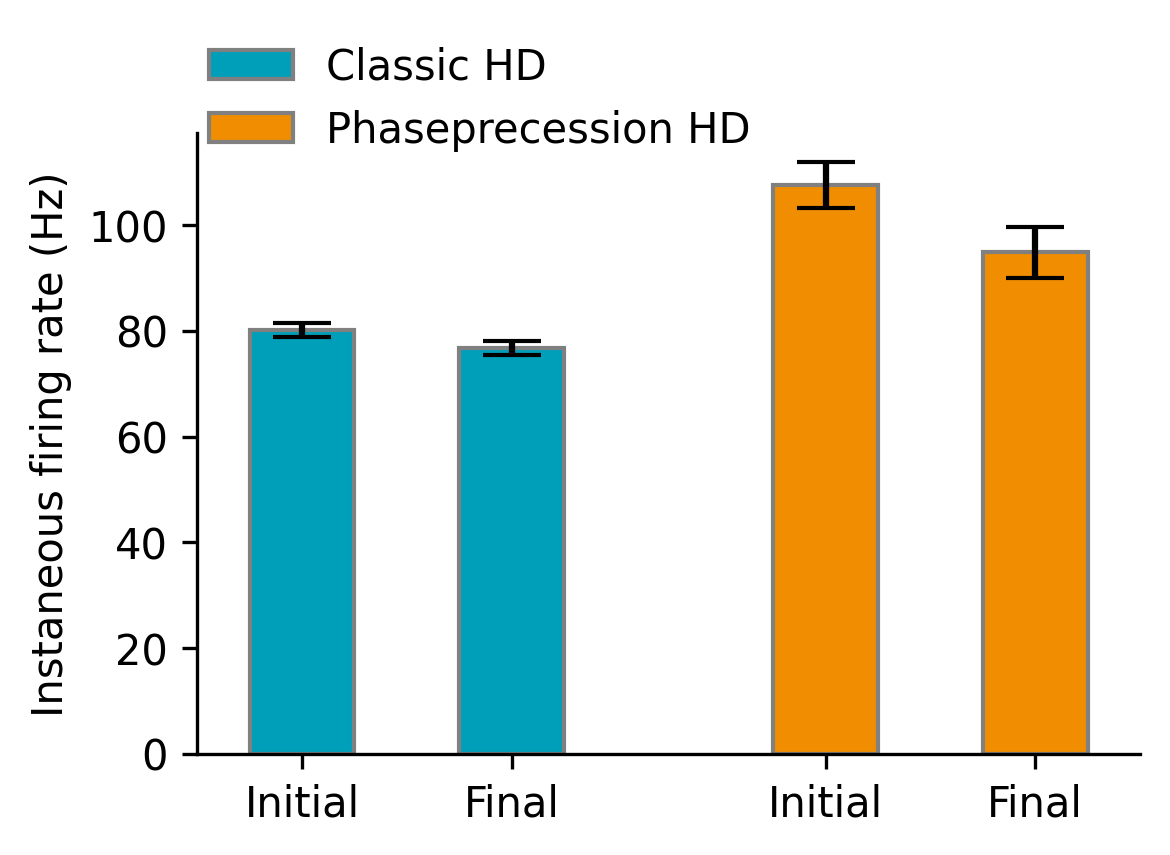

In [143]:

#plot a bar plot with cHD_init, cHD_final as a group 1 & 2, pHD_init and pHD_final as a group 3&4
#add error bars to each group

fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
barWidth = 0.5

mean_cHD_init = np.mean(cHD_init)
std_cHD_init = np.std(cHD_init)/np.sqrt(len(cHD_init))

mean_cHD_final = np.mean(cHD_final)
std_cHD_final = np.std(cHD_final)/np.sqrt(len(cHD_final))

mean_pHD_init = np.mean(pHD_init)
std_pHD_init = np.std(pHD_init)/np.sqrt(len(pHD_init))

mean_pHD_final = np.mean(pHD_final)
std_pHD_final = np.std(pHD_final)/np.sqrt(len(pHD_final))

bars1 = [mean_cHD_init, mean_cHD_final, mean_pHD_init, mean_pHD_final]
errors1 = [std_cHD_init, std_cHD_final, std_pHD_init, std_pHD_final]

r1 = np.asarray([1,2,3.5,4.5])

ax.bar(r1[0:2], bars1[0:2], yerr=errors1[0:2], color=['#009FB9', '#009FB9'], width=barWidth, edgecolor='grey', capsize=7, label='Classic HD')
ax.bar(r1[2:4], bars1[2:4], yerr=errors1[2:4], color=['#F18D00', '#F18D00'], width=barWidth, edgecolor='grey', capsize=7, label='Phaseprecession HD')


ax.set_xticks([r for r in r1])
ax.set_xticklabels(['Initial', 'Final', 'Initial', 'Final'])
ax.set_ylabel('Instaneous firing rate (Hz)')
ax.set_xlim(0.5, 5)
ax.legend(bbox_to_anchor=(0.3, 1.2), loc='upper center', frameon=False)
# ax.set_title('Firing Rate Adaptation')

sns.despine()

plt.tight_layout()

#perform wilcoxon sign rank test
from scipy.stats import wilcoxon
stat, p = wilcoxon(cHD_init, cHD_final)
print('Statistics=%.3f, p=%.3f' % (stat, p))

stat, p = wilcoxon(pHD_init, pHD_final)
print('Statistics=%.3f, p=%.3f' % (stat, p))

cHD_diff = [cHD_init[i] - cHD_final[i] for i in range(len(cHD_init))]
pHD_diff = [pHD_init[i] - pHD_final[i] for i in range(len(pHD_init))]


print(np.mean(cHD_diff), np.std(cHD_diff))
print(np.mean(pHD_diff), np.std(pHD_diff))
#perform t test for the difference
from scipy.stats import ttest_ind
stat, p = ttest_ind(cHD_diff, pHD_diff)
print('Statistics=%.3f, p=%.3f' % (stat, p))

## varying hyperparameters 

In [16]:
#varying degreerange from 6 to 20 2 is the step
degreeranges = np.arange(6, 18, 2)
#varying timecut from 0.10 to 0.50 0.05 is the step
timecuts = np.arange(0.10, 0.50, 0.05)

PVal_table = np.zeros((len(degreeranges), len(timecuts)))
FRdiff_table = np.zeros((len(degreeranges), len(timecuts)))

for i, degreerange in enumerate(degreeranges):
    for j, timecut in enumerate(timecuts):
        timelength = 2*timecut
        print(degreerange, timelength, timecut)
        results = get_adaptation_for_all(degreerange, timelength, timecut, return_mean=False)
        cHD_init = results['classicHD_initial_instfr']
        cHD_final = results['classicHD_final_instfr']
        pHD_init = results['PPHD_initial_instfr']
        pHD_final = results['PPHD_final_instfr']
        
        #3perfrom two-way ANOVA and extract the condition p value
        # Combine the data into a long-format DataFrame
        data = pd.DataFrame({
            'value': list(cHD_init) + list(cHD_final) + list(pHD_init) + list(pHD_final),
            'group': ['cHD'] * len(cHD_init) + ['cHD'] * len(cHD_final) + ['pHD'] * len(pHD_init) + ['pHD'] * len(pHD_final),
            'condition': ['init'] * len(cHD_init) + ['final'] * len(cHD_final) + ['init'] * len(pHD_init) + ['final'] * len(pHD_final)
        })
        
        # Fit the two-way ANOVA model
        model = ols('value ~ C(group) + C(condition) + C(group):C(condition)', data=data).fit()
        
        # Perform ANOVA
        anova_table = anova_lm(model, typ=2)
        
        print(anova_table)
        #extract the condition p value
        print(anova_table['PR(>F)']['C(condition)'])
        #add the condition p value to the table
        PVal_table[i, j] = anova_table['PR(>F)']['C(condition)']
        
        
        cHD_diff = [cHD_init[i] - cHD_final[i] for i in range(len(cHD_init))]
        pHD_diff = [pHD_init[i] - pHD_final[i] for i in range(len(pHD_init))]
        #concatenate the two diffs and calculate the mean, put the mean into the FRdiff_table
        FRdiff_table[i, j] = np.mean(cHD_diff + pHD_diff)
        
        

6 0.2 0.1
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_030919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_260719_T2_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_270819_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_190719_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r651/R651_200919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r651/R651_150819_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r651/R651_180819_T2_sdata.mat
'light1' not found in /home/zilong/Desktop/HD

In [30]:
import pickle
#save the PVal_table and FRdiff_table as pickle
with open('/home/zilong/Desktop/HDPhasePrecession/figures/fradaptation/PVal_table.pkl', 'wb') as f:
    pickle.dump(PVal_table, f)
    
with open('/home/zilong/Desktop/HDPhasePrecession/figures/fradaptation/FRdiff_table.pkl', 'wb') as f:
    pickle.dump(FRdiff_table, f)

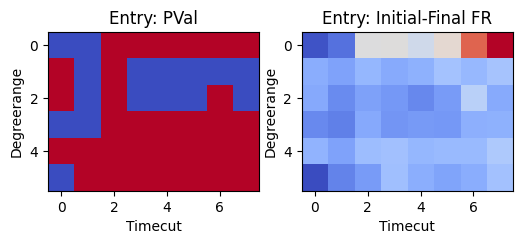

In [29]:
#plot the PVal_table fater thershold it with 0.05, means <0.05 is 1 and >0.05 is -1
PVal_table_threshold = np.where(PVal_table < 0.05, 1, -1)

fig, axs = plt.subplots(1,2,figsize=(6, 3), dpi=100)
ax = axs[0]
ax.imshow(PVal_table_threshold, cmap='coolwarm', interpolation='none')
ax.title.set_text('Entry: PVal')

#plot the FRdiff_table, with positive as red and negative as blue
ax = axs[1]
ax.imshow(FRdiff_table, cmap='coolwarm', interpolation='none')
ax.title.set_text('Entry: Initial-Final FR')

#add x and y labels
for ax in axs:
    ax.set_xlabel('Timecut')
    ax.set_ylabel('Degreerange')

    


In [7]:

#vary degreerange, timelength and timecut

# randomd sample degreerange in [6, 15]
# random sample timelength in [0.33, 1.5]
# radnom sample timecut in [0.16, 0.33] and make sure timecut < timelength/2

# do for 50 times
N = 50
results = {}
for i in range(N):
    degreerange = np.random.randint(6, 12)
    # timelength = np.random.uniform(0.33, 0.6)
    timecut = np.random.uniform(0.15, 0.25)
    timelength = 2*timecut
    # while timecut > timelength/2:
    #     timecut = np.random.uniform(0.16, 0.33)
    print(degreerange, timelength, timecut)
    result = get_adaptation_for_all(degreerange, timelength, timecut)
    results[f'{degreerange}_{timelength}_{timecut}'] = result

# #save results to a pickle file
# import pickle   
# with open('/home/zilong/Desktop/HDPhasePrecession/figures/fradaptation/results.pkl', 'wb') as f:
#     pickle.dump(results, f)

10 0.42228034007930954 0.21114017003965477
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_030919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_260719_T2_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_270819_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_190719_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r651/R651_200919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r651/R651_150819_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r651/R651_180819_T2_sdata.mat
'light1' not

10_0.42228034007930954_0.21114017003965477 {'classicHD_initial_instfr': 75.80981, 'classicHD_final_instfr': 69.092224, 'PPHD_initial_instfr': 93.57407, 'PPHD_final_instfr': 91.639206}
9_0.3434709444868531_0.17173547224342656 {'classicHD_initial_instfr': 81.7873, 'classicHD_final_instfr': 75.638466, 'PPHD_initial_instfr': 100.654, 'PPHD_final_instfr': 98.30468}
7_0.45937492593152723_0.22968746296576362 {'classicHD_initial_instfr': 73.64288, 'classicHD_final_instfr': 68.00699, 'PPHD_initial_instfr': 97.560394, 'PPHD_final_instfr': 75.42581}
8_0.39428624346375535_0.19714312173187767 {'classicHD_initial_instfr': 76.35943, 'classicHD_final_instfr': 71.16399, 'PPHD_initial_instfr': 95.30938, 'PPHD_final_instfr': 82.911316}
8_0.3541939348663507_0.17709696743317535 {'classicHD_initial_instfr': 79.33526, 'classicHD_final_instfr': 74.47346, 'PPHD_initial_instfr': 106.45799, 'PPHD_final_instfr': 103.24756}
11_0.32016998738431385_0.16008499369215692 {'classicHD_initial_instfr': 81.30138, 'classicH

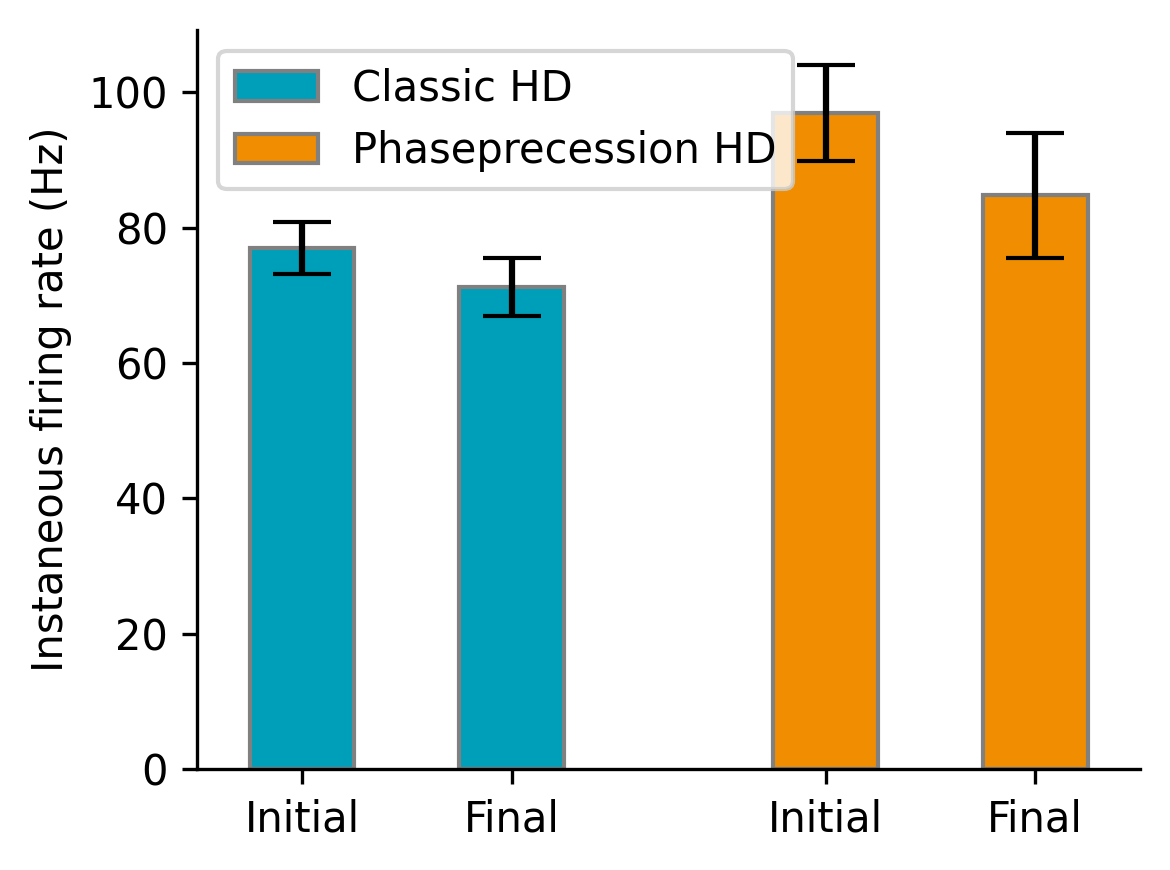

In [35]:

cHD_init = []
cHD_final = []
pHD_init = []
pHD_final = []
for key, value in results.items():
    print(key, value)
    cHD_init.append(value['classicHD_initial_instfr'])
    cHD_final.append(value['classicHD_final_instfr'])
    pHD_init.append(value['PPHD_initial_instfr'])
    pHD_final.append(value['PPHD_final_instfr'])
    
    
#plot a bar plot with cHD_init, cHD_final as a group 1 & 2, pHD_init and pHD_final as a group 3&4
#add error bars to each group

fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
barWidth = 0.5

mean_cHD_init = np.mean(cHD_init)
std_cHD_init = np.std(cHD_init)

mean_cHD_final = np.mean(cHD_final)
std_cHD_final = np.std(cHD_final)

mean_pHD_init = np.mean(pHD_init)
std_pHD_init = np.std(pHD_init)

mean_pHD_final = np.mean(pHD_final)
std_pHD_final = np.std(pHD_final)

bars1 = [mean_cHD_init, mean_cHD_final, mean_pHD_init, mean_pHD_final]
errors1 = [std_cHD_init, std_cHD_final, std_pHD_init, std_pHD_final]

r1 = np.asarray([1,2,3.5,4.5])

ax.bar(r1[0:2], bars1[0:2], yerr=errors1[0:2], color=['#009FB9', '#009FB9'], width=barWidth, edgecolor='grey', capsize=7, label='Classic HD')
ax.bar(r1[2:4], bars1[2:4], yerr=errors1[2:4], color=['#F18D00', '#F18D00'], width=barWidth, edgecolor='grey', capsize=7, label='Phaseprecession HD')


ax.set_xticks([r for r in r1])
ax.set_xticklabels(['Initial', 'Final', 'Initial', 'Final'])
ax.set_ylabel('Instaneous firing rate (Hz)')
ax.set_xlim(0.5, 5)
ax.legend()
# ax.set_title('Firing Rate Adaptation')

sns.despine()

plt.tight_layout()

#perform wilcoxon sign rank test
from scipy.stats import wilcoxon
stat, p = wilcoxon(cHD_init, cHD_final)
print('Statistics=%.3f, p=%.3f' % (stat, p))

stat, p = wilcoxon(pHD_init, pHD_final)
print('Statistics=%.3f, p=%.3f' % (stat, p))



cHD_diff = [cHD_init[i] - cHD_final[i] for i in range(len(cHD_init))]
pHD_diff = [pHD_init[i] - pHD_final[i] for i in range(len(pHD_init))]


print(np.mean(cHD_diff), np.std(cHD_diff))
print(np.mean(pHD_diff), np.std(pHD_diff))
#perform t test for the difference
from scipy.stats import ttest_ind
stat, p = ttest_ind(cHD_diff, pHD_diff)
print('Statistics=%.3f, p=%.3f' % (stat, p))